In [1]:
import sys, glob, os
SPARK_HOME=os.environ['SPARK_HOME']
sys.path.append(SPARK_HOME + "/python")
sys.path.append(glob.glob(SPARK_HOME + "/python/lib/py4j*.zip")[0])
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import pandas as pd
import numpy as np

# Create spark session
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
sc = spark.sparkContext
sql = spark.sql
print(sc.uiWebUrl)

%matplotlib inline

http://192.168.121.51:4040


In [4]:
raw = spark.read.options(header = True, inferSchema = True).csv("/data/kaggle/data_combined_cleaned.csv")
raw.limit(10).toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalesPrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000.0
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,Inside,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000.0
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,Inside,...,0,None,None,None,0,8,2007,WD,Normal,307000.0
7,8,60,RL,80.0,10382,Pave,None,IR1,Lvl,Corner,...,0,None,None,Shed,350,11,2009,WD,Normal,200000.0
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,Inside,...,0,None,None,None,0,4,2008,WD,Abnorml,129900.0
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,Corner,...,0,None,None,None,0,1,2008,WD,Normal,118000.0


In [22]:
df = raw.drop("Id").filter("Salesprice is not null")\
    .withColumn("SalesPrice", F.expr("log(Salesprice)"))
df.toPandas().head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalesPrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,...,0,None,None,None,0,2,2008,WD,Normal,12.247694
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,...,0,None,None,None,0,5,2007,WD,Normal,12.109011
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,...,0,None,None,None,0,9,2008,WD,Normal,12.317167
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,...,0,None,None,None,0,2,2006,WD,Abnorml,11.849398
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,...,0,None,None,None,0,12,2008,WD,Normal,12.429216


In [23]:
df.dtypes

[('MSSubClass', 'int'),
 ('MSZoning', 'string'),
 ('LotFrontage', 'double'),
 ('LotArea', 'int'),
 ('Street', 'string'),
 ('Alley', 'string'),
 ('LotShape', 'string'),
 ('LandContour', 'string'),
 ('LotConfig', 'string'),
 ('LandSlope', 'string'),
 ('Neighborhood', 'string'),
 ('Condition1', 'string'),
 ('Condition2', 'string'),
 ('BldgType', 'string'),
 ('HouseStyle', 'string'),
 ('OverallQual', 'int'),
 ('OverallCond', 'int'),
 ('YearBuilt', 'int'),
 ('YearRemodAdd', 'int'),
 ('RoofStyle', 'string'),
 ('RoofMatl', 'string'),
 ('Exterior1st', 'string'),
 ('Exterior2nd', 'string'),
 ('MasVnrType', 'string'),
 ('MasVnrArea', 'double'),
 ('ExterQual', 'string'),
 ('ExterCond', 'string'),
 ('Foundation', 'string'),
 ('BsmtQual', 'string'),
 ('BsmtCond', 'string'),
 ('BsmtExposure', 'string'),
 ('BsmtFinType1', 'string'),
 ('BsmtFinSF1', 'double'),
 ('BsmtFinType2', 'string'),
 ('BsmtFinSF2', 'double'),
 ('BsmtUnfSF', 'double'),
 ('TotalBsmtSF', 'double'),
 ('Heating', 'string'),
 ('Heatin

In [24]:
set([dtype for _, dtype in df.dtypes])

{'double', 'int', 'string'}

In [30]:
target = "SalesPrice"
features_cat = [field for field, dtype in df.dtypes if dtype == "string" and field != target]
features_cont = [field for field, dtype in df.dtypes if dtype != "string" and field != target]
features_cat_oh = [field + "_oh" for field in features_cat]
features_cat, features_cont, features_cat_oh

(['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'RoofStyle',
  'RoofMatl',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'ExterQual',
  'ExterCond',
  'Foundation',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Heating',
  'HeatingQC',
  'CentralAir',
  'Electrical',
  'KitchenQual',
  'Functional',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'PavedDrive',
  'PoolQC',
  'Fence',
  'MiscFeature',
  'SaleType',
  'SaleCondition'],
 ['MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbv

In [26]:
df_train, df_test = df.randomSplit([0.7, 0.3], seed = 100)

In [31]:
df_train.cache()

DataFrame[MSSubClass: int, MSZoning: string, LotFrontage: double, LotArea: int, Street: string, Alley: string, LotShape: string, LandContour: string, LotConfig: string, LandSlope: string, Neighborhood: string, Condition1: string, Condition2: string, BldgType: string, HouseStyle: string, OverallQual: int, OverallCond: int, YearBuilt: int, YearRemodAdd: int, RoofStyle: string, RoofMatl: string, Exterior1st: string, Exterior2nd: string, MasVnrType: string, MasVnrArea: double, ExterQual: string, ExterCond: string, Foundation: string, BsmtQual: string, BsmtCond: string, BsmtExposure: string, BsmtFinType1: string, BsmtFinSF1: double, BsmtFinType2: string, BsmtFinSF2: double, BsmtUnfSF: double, TotalBsmtSF: double, Heating: string, HeatingQC: string, CentralAir: string, Electrical: string, 1stFlrSF: int, 2ndFlrSF: int, LowQualFinSF: int, GrLivArea: int, BsmtFullBath: double, BsmtHalfBath: double, FullBath: int, HalfBath: int, BedroomAbvGr: int, KitchenAbvGr: int, KitchenQual: string, TotRmsAb

In [44]:
pd.options.display.max_columns = 1000

In [6]:
from pyspark.ml import Pipeline, Transformer, Estimator
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression

In [55]:
stages = []

for col in features_cat:
    string_indexer = StringIndexer(inputCol = col, outputCol= col + "_idx", handleInvalid="skip")
    ohe = OneHotEncoderEstimator(inputCols=[col + "_idx"], outputCols=[col + "_oh"])
    stages.append(string_indexer)
    stages.append(ohe)


stages.append(VectorAssembler(inputCols=(features_cont + features_cat_oh), outputCol="features"))
stages.append(StandardScaler(inputCol="features", outputCol="features_std", withMean=True))
stages.append(LinearRegression(featuresCol="features_std", labelCol=target))

pipe = Pipeline(stages = stages)
pipe_model = Pipeline(stages = stages).fit(df_train)

df_train_pred = pipe_model.transform(df_train)
df_test_pred = pipe_model.transform(df_test)

model = pipe_model.stages[-1]
model.summary.rootMeanSquaredError, model.summary.r2

(0.08956054300042283, 0.9514889495268875)

In [56]:
from pyspark.ml.evaluation import RegressionEvaluator

In [59]:
evaluator = RegressionEvaluator(predictionCol="prediction"
                        , labelCol=target, metricName="r2")
evaluator.evaluate(df_test_pred)

0.8092219559330427

In [60]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target, metricName="rmse")
evaluator.evaluate(df_test_pred)

0.16524592118522038

In [61]:
df_test.select(target).describe().show()

+-------+------------------+
|summary|        SalesPrice|
+-------+------------------+
|  count|               440|
|   mean|12.027626898794686|
| stddev|0.3822366997002864|
|    min|10.858998997563564|
|    max|13.345506928718539|
+-------+------------------+



In [62]:
est = pipe_model.stages[-1]
est

LinearRegression_4783bdde3e290d4bc65b

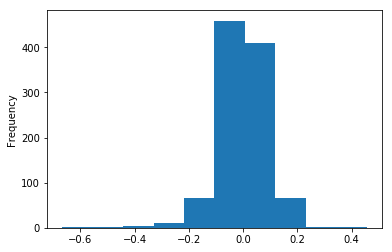

In [63]:
est.summary.residuals.toPandas().residuals.plot.hist()

In [64]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [69]:
evaluator = RegressionEvaluator(predictionCol="prediction"
                                , labelCol=target, metricName="rmse")

pipe = Pipeline(stages = stages)
paramGrid = (ParamGridBuilder()
    .addGrid(stages[-1].regParam, np.linspace(0.001, 1.0, 10)) 
    #.addGrid(lr.fitIntercept, [False, True])
    #.addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build())

# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=pipe,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

tuned_model = tvs.fit(df_train)

In [73]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target, metricName="r2")
evaluator.evaluate(tuned_model.bestModel.transform(df_test))

0.8696537119711105

In [5]:
df = spark.read.options(header = True, inferSchema = True).csv("/data/insurance.csv")
df.show()

+---+------+------+--------+------+---------+-----------+
|age|gender|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [10]:
region_indexer = StringIndexer(inputCol="region", outputCol="region_index")
df_idx = region_indexer.fit(df).transform(df)
df_idx.show()

+---+------+------+--------+------+---------+-----------+------------+
|age|gender|   bmi|children|smoker|   region|    charges|region_index|
+---+------+------+--------+------+---------+-----------+------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|         1.0|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|         0.0|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|         0.0|
| 33|  male|22.705|       0|    no|northwest|21984.47061|         2.0|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|         2.0|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|         0.0|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|         0.0|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|         2.0|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|         3.0|
| 60|female| 25.84|       0|    no|northwest|28923.13692|         2.0|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|         3.0|
| 62|f

In [14]:
region_oh = OneHotEncoderEstimator(inputCols=["region_index"],dropLast=False, outputCols=["region_oh"])
df_oh = region_oh.fit(df_idx).transform(df_idx)
df_oh.show()

+---+------+------+--------+------+---------+-----------+------------+-------------+
|age|gender|   bmi|children|smoker|   region|    charges|region_index|    region_oh|
+---+------+------+--------+------+---------+-----------+------------+-------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|         1.0|(4,[1],[1.0])|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|         0.0|(4,[0],[1.0])|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|         0.0|(4,[0],[1.0])|
| 33|  male|22.705|       0|    no|northwest|21984.47061|         2.0|(4,[2],[1.0])|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|         2.0|(4,[2],[1.0])|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|         0.0|(4,[0],[1.0])|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|         0.0|(4,[0],[1.0])|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|         2.0|(4,[2],[1.0])|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|        

In [15]:
df_oh.toPandas()

,age,gender,bmi,children,smoker,region,charges,region_index,region_oh
0,19,female,27.900,0,yes,southwest,16884.92400,1.0,"(0.0, 1.0, 0.0, 0.0)"
1,18,male,33.770,1,no,southeast,1725.55230,0.0,"(1.0, 0.0, 0.0, 0.0)"
2,28,male,33.000,3,no,southeast,4449.46200,0.0,"(1.0, 0.0, 0.0, 0.0)"
3,33,male,22.705,0,no,northwest,21984.47061,2.0,"(0.0, 0.0, 1.0, 0.0)"
4,32,male,28.880,0,no,northwest,3866.85520,2.0,"(0.0, 0.0, 1.0, 0.0)"
5,31,female,25.740,0,no,southeast,3756.62160,0.0,"(1.0, 0.0, 0.0, 0.0)"
6,46,female,33.440,1,no,southeast,8240.58960,0.0,"(1.0, 0.0, 0.0, 0.0)"
7,37,female,27.740,3,no,northwest,7281.50560,2.0,"(0.0, 0.0, 1.0, 0.0)"
8,37,male,29.830,2,no,northeast,6406.41070,3.0,"(0.0, 0.0, 0.0, 1.0)"
9,60,female,25.840,0,no,northwest,28923.13692,2.0,"(0.0, 0.0, 1.0, 0.0)"


In [20]:
vector_assembler = VectorAssembler(inputCols=["age", "region_oh"], outputCol="features")
df_vectorized = vector_assembler.transform(df_oh)
df_vectorized.toPandas()

,age,gender,bmi,children,smoker,region,charges,region_index,region_oh,features
0,19,female,27.900,0,yes,southwest,16884.92400,1.0,"(0.0, 1.0, 0.0, 0.0)","(19.0, 0.0, 1.0, 0.0, 0.0)"
1,18,male,33.770,1,no,southeast,1725.55230,0.0,"(1.0, 0.0, 0.0, 0.0)","(18.0, 1.0, 0.0, 0.0, 0.0)"
2,28,male,33.000,3,no,southeast,4449.46200,0.0,"(1.0, 0.0, 0.0, 0.0)","(28.0, 1.0, 0.0, 0.0, 0.0)"
3,33,male,22.705,0,no,northwest,21984.47061,2.0,"(0.0, 0.0, 1.0, 0.0)","(33.0, 0.0, 0.0, 1.0, 0.0)"
4,32,male,28.880,0,no,northwest,3866.85520,2.0,"(0.0, 0.0, 1.0, 0.0)","(32.0, 0.0, 0.0, 1.0, 0.0)"
5,31,female,25.740,0,no,southeast,3756.62160,0.0,"(1.0, 0.0, 0.0, 0.0)","(31.0, 1.0, 0.0, 0.0, 0.0)"
6,46,female,33.440,1,no,southeast,8240.58960,0.0,"(1.0, 0.0, 0.0, 0.0)","(46.0, 1.0, 0.0, 0.0, 0.0)"
7,37,female,27.740,3,no,northwest,7281.50560,2.0,"(0.0, 0.0, 1.0, 0.0)","(37.0, 0.0, 0.0, 1.0, 0.0)"
8,37,male,29.830,2,no,northeast,6406.41070,3.0,"(0.0, 0.0, 0.0, 1.0)","(37.0, 0.0, 0.0, 0.0, 1.0)"
9,60,female,25.840,0,no,northwest,28923.13692,2.0,"(0.0, 0.0, 1.0, 0.0)","(60.0, 0.0, 0.0, 1.0, 0.0)"


In [21]:
scaler = StandardScaler(withMean=True, inputCol="features", outputCol="features_std")
scaler.fit(df_vectorized).transform(df_vectorized).toPandas()

,age,gender,bmi,children,smoker,region,charges,region_index,region_oh,features,features_std
0,19,female,27.900,0,yes,southwest,16884.92400,1.0,"(0.0, 1.0, 0.0, 0.0)","(19.0, 0.0, 1.0, 0.0, 0.0)","[-1.4382265049624725, -0.6110951828920052, 1.7..."
1,18,male,33.770,1,no,southeast,1725.55230,0.0,"(1.0, 0.0, 0.0, 0.0)","(18.0, 1.0, 0.0, 0.0, 0.0)","[-1.5094010828978865, 1.6351832641121238, -0.5..."
2,28,male,33.000,3,no,southeast,4449.46200,0.0,"(1.0, 0.0, 0.0, 0.0)","(28.0, 1.0, 0.0, 0.0, 0.0)","[-0.7976553035437455, 1.6351832641121238, -0.5..."
3,33,male,22.705,0,no,northwest,21984.47061,2.0,"(0.0, 0.0, 1.0, 0.0)","(33.0, 0.0, 0.0, 1.0, 0.0)","[-0.4417824138666749, -0.6110951828920052, -0...."
4,32,male,28.880,0,no,northwest,3866.85520,2.0,"(0.0, 0.0, 1.0, 0.0)","(32.0, 0.0, 0.0, 1.0, 0.0)","[-0.512956991802089, -0.6110951828920052, -0.5..."
5,31,female,25.740,0,no,southeast,3756.62160,0.0,"(1.0, 0.0, 0.0, 0.0)","(31.0, 1.0, 0.0, 0.0, 0.0)","[-0.5841315697375031, 1.6351832641121238, -0.5..."
6,46,female,33.440,1,no,southeast,8240.58960,0.0,"(1.0, 0.0, 0.0, 0.0)","(46.0, 1.0, 0.0, 0.0, 0.0)","[0.48348709929370853, 1.6351832641121238, -0.5..."
7,37,female,27.740,3,no,northwest,7281.50560,2.0,"(0.0, 0.0, 1.0, 0.0)","(37.0, 0.0, 0.0, 1.0, 0.0)","[-0.15708410212501847, -0.6110951828920052, -0..."
8,37,male,29.830,2,no,northeast,6406.41070,3.0,"(0.0, 0.0, 0.0, 1.0)","(37.0, 0.0, 0.0, 0.0, 1.0)","[-0.15708410212501847, -0.6110951828920052, -0..."
9,60,female,25.840,0,no,northwest,28923.13692,2.0,"(0.0, 0.0, 1.0, 0.0)","(60.0, 0.0, 0.0, 1.0, 0.0)","[1.479931190389506, -0.6110951828920052, -0.56..."
